# GPT (Small version)

Implement incrementally a small version of the GPT to be trained on Tiny Shakespeare

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1337)
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
%matplotlib inline

## Read the dataset

In [2]:
with open("./data/tiny-shakespeare/input.txt") as file:
    data = file.read()

len(data)

1115394

In [5]:
display(Markdown(data[:1000]))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
chars = sorted(list(set(data)))
chars

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [7]:
len(chars)

65

In [8]:
stoi = {c:i for i, c in enumerate(chars)}
itos = {i:c for i, c in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])

In [9]:
encoded_word = encode('hello world')
decoded_word = decode(encoded_word)
print(encoded_word)
print(decoded_word)

[46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
hello world


In [10]:
def get_batch(tokens, block_size, batch_size):
    batch = torch.randint(0, len(tokens)-block_size, (batch_size,)) # B dimension array of random indices
    Xb = torch.stack([torch.LongTensor(tokens[i:i+block_size]) for i in batch], dim=0) # Create (B, T) dimension array
    yb = torch.stack([torch.LongTensor(tokens[i+1:i+block_size+1]) for i in batch], dim=0) # Create (B, T) dimension array
    return Xb, yb

In [11]:
@torch.no_grad()
def compute_loss(tokens, block_size, batch_size, model, device):
    loss_values = []
    for _ in range(1000):
        Xb, yb = get_batch(tokens, block_size, batch_size)
        Xb, yb = Xb.to(device), yb.to(device)

        _, loss = model(Xb, yb)
        loss_values.append(loss.item())

    mean_loss = torch.FloatTensor(loss_values).mean().item()
    return mean_loss

In [232]:
def train(train_tokens, val_tokens, model, optimizer, device, block_size, batch_size, n_iters, eval_interval):
    train_lossi, val_lossi = [], []
    
    for i in range(n_iters):
        model.train()
        Xb, yb = get_batch(train_tokens, block_size, batch_size)
        Xb, yb = Xb.to(device), yb.to(device)

        # forward
        _, loss = model(Xb, yb)

        # set grads to zero
        optimizer.zero_grad(set_to_none=True)

        # do backward
        loss.backward()

        # optimizer step
        optimizer.step()

        if i % eval_interval == 0:
            model.eval()
            train_loss = compute_loss(train_tokens, block_size, batch_size, model, device)
            val_loss = compute_loss(val_tokens, block_size, batch_size, model, device)

            train_lossi.append(train_loss)
            val_lossi.append(val_loss)

            print(f"Step {i}/{n_iters} --> Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        # break

    return train_lossi, val_lossi

In [70]:
tokens = encode(data)
len(tokens)

1115394

In [71]:
data_size = len(tokens)
split_idx = int(0.8 * data_size)
train_tokens = tokens[:split_idx]
val_tokens = tokens[split_idx:]
len(train_tokens), len(val_tokens)

(892315, 223079)

## Idea 1 : Create a decoder self attention block (single head). Add position embeddings to that since attention is space invariant

In [72]:
class SelfAttentionDecoder(nn.Module):
    def __init__(self, channel_dim, head_dim, block_size, device):
        super().__init__()
        self.device = device
        self.k_project = nn.Linear(channel_dim, head_dim, bias=False, device=self.device)
        self.q_project = nn.Linear(channel_dim, head_dim, bias=False, device=self.device)
        self.v_project = nn.Linear(channel_dim, head_dim, bias=False, device=self.device)
        mask = torch.triu(torch.ones(block_size, block_size), diagonal=1).bool().to(self.device)
        self.register_buffer('mask', mask)

    def forward(self, x):
        # x shape: (B, T, C)
        # create keys queries and values
        k, q, v = self.k_project(x), self.q_project(x), self.v_project(x) # all shaped (B, T, H)
        # get the weights
        B, T, H = k.shape
        wei = (q @ k.transpose(-2, -1)) * (H**-0.5) # B,T,H @ B,H,T --> B,T,T
        wei = wei.masked_fill(self.mask, float('-inf')) # B,T,T
        wei = torch.softmax(wei, dim=-1)
        # get the out
        out = wei @ v # (B,T,T) @ (B,T,H) -> (B,T,H)
        return out

In [73]:
class LM1(nn.Module):
    def __init__(self, emb_dim, vocab_size, block_size, device):
        super().__init__()
        self.device = device
        # get the embeddings matrix
        self.tok_embs = nn.Embedding(vocab_size, emb_dim, device=self.device)
        self.pos_embs = nn.Embedding(block_size, emb_dim, device=self.device)

        # get a attention layer
        self.sa = SelfAttentionDecoder(emb_dim, emb_dim, block_size, device=self.device)

        # Final linear layer
        self.lm_layer = nn.Linear(emb_dim, vocab_size, device=self.device)

        print(f"No. of parameters: {sum([p.numel() for p in self.parameters()])}")

    def forward(self, x, targets=None):
        # x shape (B, T), targets shape (B, T)
        x, targets = x.to(self.device), targets.to(self.device)
        B, T = x.shape
        token_embs = self.tok_embs(x) #(B,T,C)
        position_embs = self.pos_embs(torch.arange(T).to(self.device)) #(T,C)
        embs = token_embs + position_embs
        att_embs = self.sa(embs) # (B,T,C) -> (B,T,H=C)
        logits = self.lm_layer(att_embs)

        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss

In [74]:
emb_dim= 32
head_dim = 32
batch_size = 32
vocab_size = len(stoi)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
block_size = 8
lr = 3e-4
n_iters = 10000
eval_interval = n_iters//10

In [75]:
model = LM1(emb_dim=emb_dim, vocab_size=vocab_size, block_size=block_size, device=device)

No. of parameters: 7553


In [76]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [77]:
train_lossi, val_lossi = train(train_tokens=train_tokens, val_tokens=val_tokens, model=model, optimizer=optimizer,\
      device=device, block_size=block_size, batch_size=batch_size, n_iters=n_iters, eval_interval=eval_interval)

Step 0/10000 --> Train: 4.3073 | Val: 4.3078
Step 1000/10000 --> Train: 2.9490 | Val: 2.9687
Step 2000/10000 --> Train: 2.7493 | Val: 2.7666
Step 3000/10000 --> Train: 2.5823 | Val: 2.6050
Step 4000/10000 --> Train: 2.5073 | Val: 2.5292
Step 5000/10000 --> Train: 2.4672 | Val: 2.4907
Step 6000/10000 --> Train: 2.4415 | Val: 2.4713
Step 7000/10000 --> Train: 2.4285 | Val: 2.4550
Step 8000/10000 --> Train: 2.4195 | Val: 2.4461
Step 9000/10000 --> Train: 2.4073 | Val: 2.4373


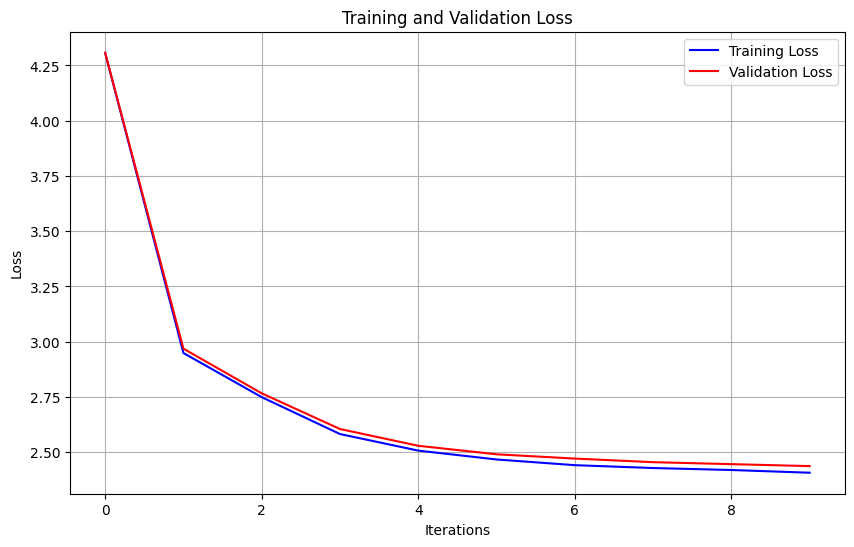

In [78]:
# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(train_lossi, label='Training Loss', color='blue')
plt.plot(val_lossi, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Idea 2: Implement MultiHead attention

We want each head to communicate a certain idea from the previous tokens

In [165]:
class SelfAttentionDecoder(nn.Module):
    def __init__(self, channel_dim, head_dim, block_size, device):
        super().__init__()
        self.device = device
        self.k_project = nn.Linear(channel_dim, head_dim, bias=False, device=self.device)
        self.q_project = nn.Linear(channel_dim, head_dim, bias=False, device=self.device)
        self.v_project = nn.Linear(channel_dim, head_dim, bias=False, device=self.device)
        mask = torch.triu(torch.ones(block_size, block_size), diagonal=1).bool().to(self.device)
        self.register_buffer('mask', mask)

    def forward(self, x):
        # x shape: (B, T, C)
        # create keys queries and values
        k, q, v = self.k_project(x), self.q_project(x), self.v_project(x) # all shaped (B, T, H)

        # get the weights
        B, T, H = k.shape
        wei = (q @ k.transpose(-2, -1)) * (H**-0.5) # B,T,H @ B,H,T --> B,T,T
        wei = wei.masked_fill(self.mask[:T, :T], float('-inf')) # B,T,T
        wei = torch.softmax(wei, dim=-1)
        # get the out
        out = wei @ v # (B,T,T) @ (B,T,H) -> (B,T,H)
        return out
    
class MultiHeadSelfAttentionDecoder(nn.Module):
    def __init__(self, channel_dim, num_heads, block_size, device):
        super().__init__()
        self.device = device
        self.mha_decoder = nn.Sequential(*[SelfAttentionDecoder(channel_dim, channel_dim//num_heads, block_size, device) for _ in range(num_heads)])\
            .to(device=self.device)
    
    def forward(self, x):
        # x shape: (B,T,C)
        out = torch.cat([head(x) for head in self.mha_decoder], dim=-1) # head (x) -> (B,T,C//NH) * NH -> [B,T,C]
        return out

In [166]:
class LM2(nn.Module):
    def __init__(self, emb_dim, vocab_size, block_size, num_heads, device):
        super().__init__()
        self.device = device
        self.block_size = block_size
        # get the embeddings matrix
        self.tok_embs = nn.Embedding(vocab_size, emb_dim, device=self.device)
        self.pos_embs = nn.Embedding(block_size, emb_dim, device=self.device)

        # get a attention layer
        self.mha = MultiHeadSelfAttentionDecoder(emb_dim, num_heads, block_size, device=self.device)

        # Final linear layer
        self.lm_layer = nn.Linear(emb_dim, vocab_size, device=self.device)

        print(f"No. of parameters: {sum([p.numel() for p in self.parameters()])}")

    def forward(self, x, targets=None):
        # x shape (B, T), targets shape (B, T)
        x = x.to(self.device)
        B, T = x.shape
        token_embs = self.tok_embs(x) #(B,T,C)
        position_embs = self.pos_embs(torch.arange(T).to(self.device)) #(T,C)
        embs = token_embs + position_embs
        att_embs = self.mha(embs) # (B,T,C) -> (B,T,C//NH)*NH
        logits = self.lm_layer(att_embs)

        if targets is None:
            loss = None
        else:
            targets = targets.to(self.device)
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss
    
    def generate(self, max_tokens=1000):
        curr_block, curr_str = torch.LongTensor([[0]]).to(self.device), "\n"

        for _ in range(max_tokens):
            # truncate window to block_size
            curr_block = curr_block[:, -self.block_size:] # [B,R] -> [B,T]

            logits, _ = self(curr_block) # (B,T,V)
            probs = torch.softmax(logits, dim=-1) # (B,T,V)
            B, T, V = probs.shape
            new_char_idx = torch.multinomial(probs.view(B*T, V), num_samples=1, replacement=True)[-1].item()
            curr_str += itos[new_char_idx]
            new_char_idx = torch.LongTensor([new_char_idx]).unsqueeze(0).to(device)
            curr_block = torch.cat([curr_block, new_char_idx], dim=1)

        return curr_str

In [167]:
emb_dim= 32
num_heads = 4
batch_size = 32
vocab_size = len(stoi)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
block_size = 8
lr = 3e-4
n_iters = 10000
eval_interval = n_iters//10

In [168]:
model = LM2(emb_dim=emb_dim, vocab_size=vocab_size, block_size=block_size, num_heads=num_heads, device=device)

No. of parameters: 7553


In [169]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [170]:
train_lossi, val_lossi = train(train_tokens=train_tokens, val_tokens=val_tokens, model=model, optimizer=optimizer,\
      device=device, block_size=block_size, batch_size=batch_size, n_iters=n_iters, eval_interval=eval_interval)

Step 0/10000 --> Train: 4.2659 | Val: 4.2691
Step 1000/10000 --> Train: 2.8462 | Val: 2.8614
Step 2000/10000 --> Train: 2.6138 | Val: 2.6310
Step 3000/10000 --> Train: 2.5192 | Val: 2.5402
Step 4000/10000 --> Train: 2.4666 | Val: 2.4941
Step 5000/10000 --> Train: 2.4300 | Val: 2.4537
Step 6000/10000 --> Train: 2.3991 | Val: 2.4329
Step 7000/10000 --> Train: 2.3756 | Val: 2.4117
Step 8000/10000 --> Train: 2.3573 | Val: 2.3927
Step 9000/10000 --> Train: 2.3401 | Val: 2.3745


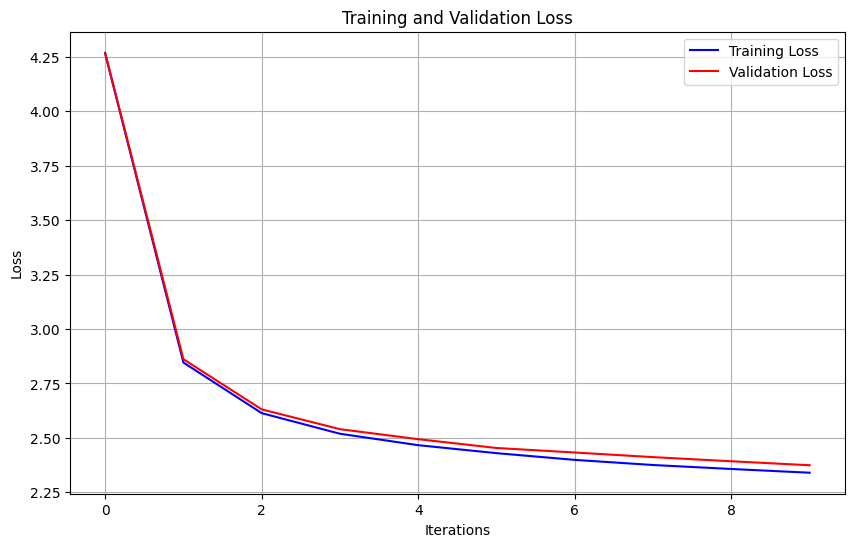

In [171]:
# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(train_lossi, label='Training Loss', color='blue')
plt.plot(val_lossi, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [172]:
sample = model.generate()
display(Markdown(sample))


IX:
I oucet lerr-y mord'd mrouke the.


Mer.

ORHLAPUNRGOOUICYSord llend tace'cken siz shouren ote you,
And aler mret kth, itha meat forne kie,
Aen,
N
And
Thr co lemon,
Fourienee,
Sof die non as othorgethous?

Bre youtrach of ancu and yigh noue sath facr thar eght dors ki, farme.

AWI:
UCELACAFUREBER:
O'npingh phres whors;
Matthinot nou wit-ehe uves so go hoy
Louts so ponke fea cancmout ke,
ME:
May for nopr kas? fay mebs
Har uatlis toof his nend mavepilithacpald me, hat wamathar it me:
Nl'd
Thery
Am tordpmen by mas en, team. I ato me one keent.

JCETER:
Herth,
Burenole frod.
CAnd farom, pwis for,
JThe mou measole yer, whals gorslu suthairds angh trousanl.
An;
COue gay gor cows for,
C, ghld;
AB.

The youe son Eo Wanf you psthe
AnTy:
AUCRKONBELO:
Then ram my frord a thathind mrad is we.

SLOusl,
L-rme Weebu.A:
Can love! os, Fre mhivey,
That his Mro
Thiby rat, con if ESAUCAnd as we, pof seramend bly
PH:
Why vou wedan:
Arth,-es, lo, datu leralmporu dats wour dhe
JI atwheugr bech:
G Yeat; r

## Idea 3: Add a Linear after attention

This gives model time to think about the tokens

In [180]:
class LM3(nn.Module):
    def __init__(self, emb_dim, vocab_size, block_size, num_heads, device):
        super().__init__()
        self.device = device
        self.block_size = block_size
        # get the embeddings matrix
        self.tok_embs = nn.Embedding(vocab_size, emb_dim, device=self.device)
        self.pos_embs = nn.Embedding(block_size, emb_dim, device=self.device)

        # get a attention layer
        self.mha = MultiHeadSelfAttentionDecoder(emb_dim, num_heads, block_size, device=self.device)
        self.ffn = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.ReLU(),
            nn.Linear(4 * emb_dim, emb_dim)
        ).to(self.device)
        # Final linear layer
        self.lm_layer = nn.Linear(emb_dim, vocab_size, device=self.device)

        print(f"No. of parameters: {sum([p.numel() for p in self.parameters()])}")

    def forward(self, x, targets=None):
        # x shape (B, T), targets shape (B, T)
        x = x.to(self.device)
        B, T = x.shape
        token_embs = self.tok_embs(x) #(B,T,C)
        position_embs = self.pos_embs(torch.arange(T).to(self.device)) #(T,C)
        embs = token_embs + position_embs
        att_embs = self.mha(embs) # (B,T,C) -> (B,T,C//NH)*NH
        ffn_embs = self.ffn(att_embs)
        logits = self.lm_layer(ffn_embs)

        if targets is None:
            loss = None
        else:
            targets = targets.to(self.device)
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss
    
    def generate(self, max_tokens=1000):
        curr_block, curr_str = torch.LongTensor([[0]]).to(self.device), "\n"

        for _ in range(max_tokens):
            # truncate window to block_size
            curr_block = curr_block[:, -self.block_size:] # [B,R] -> [B,T]

            logits, _ = self(curr_block) # (B,T,V)
            probs = torch.softmax(logits, dim=-1) # (B,T,V)
            B, T, V = probs.shape
            new_char_idx = torch.multinomial(probs.view(B*T, V), num_samples=1, replacement=True)[-1].item()
            curr_str += itos[new_char_idx]
            new_char_idx = torch.LongTensor([new_char_idx]).unsqueeze(0).to(device)
            curr_block = torch.cat([curr_block, new_char_idx], dim=1)

        return curr_str

In [181]:
emb_dim= 32
num_heads = 4
batch_size = 32
vocab_size = len(stoi)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
block_size = 8
lr = 3e-4
n_iters = 10000
eval_interval = n_iters//10

In [182]:
model = LM3(emb_dim=emb_dim, vocab_size=vocab_size, block_size=block_size, num_heads=num_heads, device=device)

No. of parameters: 15905


In [183]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [184]:
train_lossi, val_lossi = train(train_tokens=train_tokens, val_tokens=val_tokens, model=model, optimizer=optimizer,\
      device=device, block_size=block_size, batch_size=batch_size, n_iters=n_iters, eval_interval=eval_interval)

Step 0/10000 --> Train: 4.1689 | Val: 4.1686
Step 1000/10000 --> Train: 2.6159 | Val: 2.6431
Step 2000/10000 --> Train: 2.4799 | Val: 2.5066
Step 3000/10000 --> Train: 2.4172 | Val: 2.4398
Step 4000/10000 --> Train: 2.3648 | Val: 2.3941
Step 5000/10000 --> Train: 2.3316 | Val: 2.3633
Step 6000/10000 --> Train: 2.2950 | Val: 2.3335
Step 7000/10000 --> Train: 2.2769 | Val: 2.3114
Step 8000/10000 --> Train: 2.2533 | Val: 2.2964
Step 9000/10000 --> Train: 2.2360 | Val: 2.2765


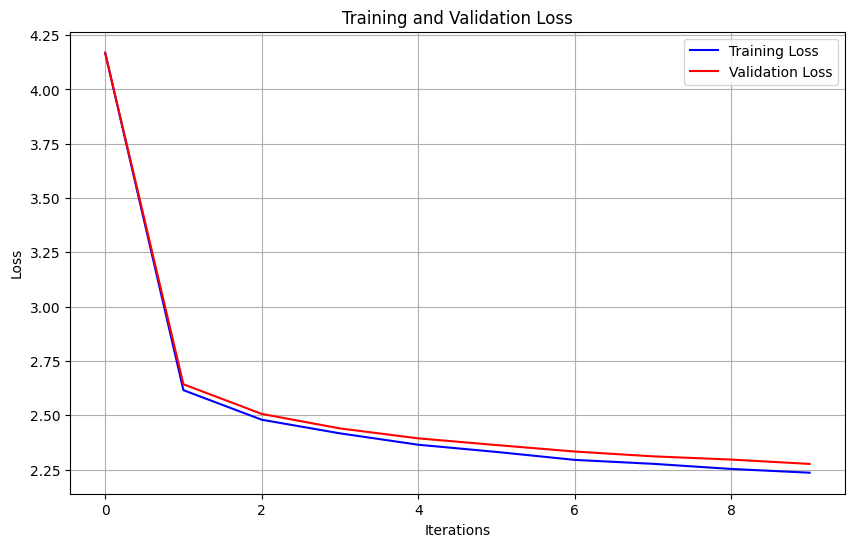

In [185]:
# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(train_lossi, label='Training Loss', color='blue')
plt.plot(val_lossi, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [186]:
sample = model.generate()
display(Markdown(sample))


Tarmey. Sard,
Wham ithes, ase tape.

FOVNRD CE peanf:
The beat haght thil.
Whe perfeat vencef thish oneer's Moew cy the of the jre yountech?
Fo nus soncedn oush a lorder
AV:
Sake the,
Yow of meary to tu linju is youlles?

Korsey tort.

ROucweve dand eare:
Here'ge yerbe shans WGLAU:
Hoand shath at the of co saws
The bis gois.

COUSII:
ARENI:
FUCERD:
Eiftuereliight dioms fold;
I cor ingllf tand Go In, a tacobasst belut, an ther tisof trupeid ith then pewwhe pear, so to to meard's Whall deaem soo uncateacto Gome seoutter.

Wive eardlees lou'l of mily Fealol, was, mon the trorkinceeve lard peaste, thealet sie; tho unth so the ping ther siet fole laetelt that dat a fe; moolpeint the toor dos'd Mod lave whargiert gowl'd bre thue wat and byoule to mald domed
Thave of as the tant aln
O.

F'om it wamim
Pvely.

UNLEING:
Sings
I
for youim man grow and den that;
Whe 'ang meed and the rearte my tro mean the sid;
NRCIESTAR:
Icire; the entes, the her:
Thith alll prot so f nome.

Whou bege mut ne hat.

## Idea 4: Add LayerNorm to the network

In [193]:
class LM4(nn.Module):
    def __init__(self, emb_dim, vocab_size, block_size, num_heads, device):
        super().__init__()
        self.device = device
        self.block_size = block_size
        # get the embeddings matrix
        self.tok_embs = nn.Embedding(vocab_size, emb_dim, device=self.device)
        self.pos_embs = nn.Embedding(block_size, emb_dim, device=self.device)

        self.ln1 = nn.LayerNorm(emb_dim, device=self.device)

        # get a attention layer
        self.mha = MultiHeadSelfAttentionDecoder(emb_dim, num_heads, block_size, device=self.device)

        self.ln2 = nn.LayerNorm(emb_dim, device=self.device)
        self.ffn = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.ReLU(),
            nn.Linear(4 * emb_dim, emb_dim)
        ).to(self.device)
        
        # Final linear layer
        self.ln3 = nn.LayerNorm(emb_dim, device=self.device)
        self.lm_layer = nn.Linear(emb_dim, vocab_size, device=self.device)

        print(f"No. of parameters: {sum([p.numel() for p in self.parameters()])}")

    def forward(self, x, targets=None):
        # x shape (B, T), targets shape (B, T)
        x = x.to(self.device)
        B, T = x.shape
        token_embs = self.tok_embs(x) #(B,T,C)
        position_embs = self.pos_embs(torch.arange(T).to(self.device)) #(T,C)
        embs = token_embs + position_embs
        embs = self.ln1(embs)
        embs = self.mha(embs)
        embs = self.ln2(embs)
        embs = self.ffn(embs)
        embs = self.ln3(embs)
        logits = self.lm_layer(embs)

        if targets is None:
            loss = None
        else:
            targets = targets.to(self.device)
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss
    
    def generate(self, max_tokens=1000):
        curr_block, curr_str = torch.LongTensor([[0]]).to(self.device), "\n"

        for _ in range(max_tokens):
            # truncate window to block_size
            curr_block = curr_block[:, -self.block_size:] # [B,R] -> [B,T]

            logits, _ = self(curr_block) # (B,T,V)
            probs = torch.softmax(logits, dim=-1) # (B,T,V)
            B, T, V = probs.shape
            new_char_idx = torch.multinomial(probs.view(B*T, V), num_samples=1, replacement=True)[-1].item()
            curr_str += itos[new_char_idx]
            new_char_idx = torch.LongTensor([new_char_idx]).unsqueeze(0).to(device)
            curr_block = torch.cat([curr_block, new_char_idx], dim=1)

        return curr_str

In [194]:
emb_dim= 32
num_heads = 4
batch_size = 32
vocab_size = len(stoi)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
block_size = 8
lr = 3e-4
n_iters = 10000
eval_interval = n_iters//10

In [195]:
model = LM4(emb_dim=emb_dim, vocab_size=vocab_size, block_size=block_size, num_heads=num_heads, device=device)

No. of parameters: 16097


In [196]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [197]:
train_lossi, val_lossi = train(train_tokens=train_tokens, val_tokens=val_tokens, model=model, optimizer=optimizer,\
      device=device, block_size=block_size, batch_size=batch_size, n_iters=n_iters, eval_interval=eval_interval)

Step 0/10000 --> Train: 4.2419 | Val: 4.2471
Step 1000/10000 --> Train: 2.5249 | Val: 2.5473
Step 2000/10000 --> Train: 2.3719 | Val: 2.4042
Step 3000/10000 --> Train: 2.2870 | Val: 2.3363
Step 4000/10000 --> Train: 2.2370 | Val: 2.2840
Step 5000/10000 --> Train: 2.2064 | Val: 2.2621
Step 6000/10000 --> Train: 2.1719 | Val: 2.2388
Step 7000/10000 --> Train: 2.1467 | Val: 2.2067
Step 8000/10000 --> Train: 2.1325 | Val: 2.2059
Step 9000/10000 --> Train: 2.1181 | Val: 2.1945


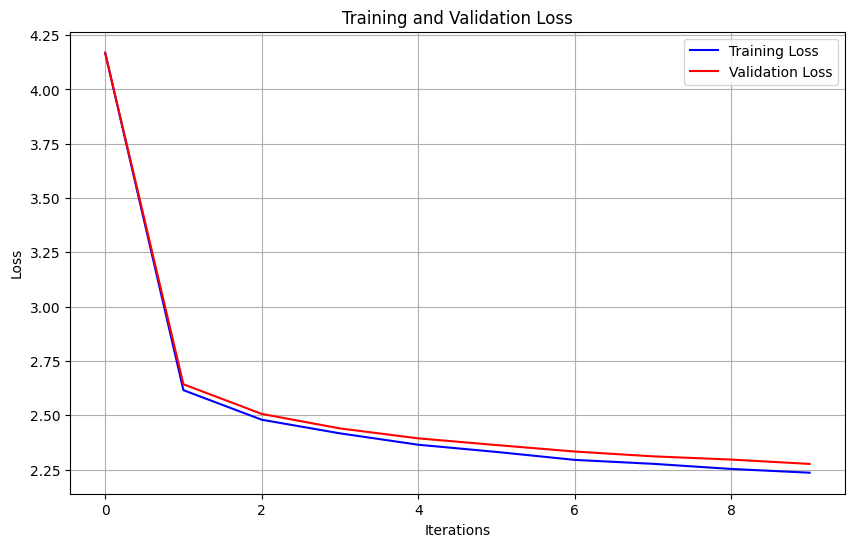

In [ ]:
# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(train_lossi, label='Training Loss', color='blue')
plt.plot(val_lossi, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
sample = model.generate()
display(Markdown(sample))


Tarmey. Sard,
Wham ithes, ase tape.

FOVNRD CE peanf:
The beat haght thil.
Whe perfeat vencef thish oneer's Moew cy the of the jre yountech?
Fo nus soncedn oush a lorder
AV:
Sake the,
Yow of meary to tu linju is youlles?

Korsey tort.

ROucweve dand eare:
Here'ge yerbe shans WGLAU:
Hoand shath at the of co saws
The bis gois.

COUSII:
ARENI:
FUCERD:
Eiftuereliight dioms fold;
I cor ingllf tand Go In, a tacobasst belut, an ther tisof trupeid ith then pewwhe pear, so to to meard's Whall deaem soo uncateacto Gome seoutter.

Wive eardlees lou'l of mily Fealol, was, mon the trorkinceeve lard peaste, thealet sie; tho unth so the ping ther siet fole laetelt that dat a fe; moolpeint the toor dos'd Mod lave whargiert gowl'd bre thue wat and byoule to mald domed
Thave of as the tant aln
O.

F'om it wamim
Pvely.

UNLEING:
Sings
I
for youim man grow and den that;
Whe 'ang meed and the rearte my tro mean the sid;
NRCIESTAR:
Icire; the entes, the her:
Thith alll prot so f nome.

Whou bege mut ne hat.

## Idea 5: Add Residual Connections to the network

In [212]:
class LM5(nn.Module):
    def __init__(self, emb_dim, vocab_size, block_size, num_heads, device):
        super().__init__()
        self.device = device
        self.block_size = block_size
        # get the embeddings matrix
        self.tok_embs = nn.Embedding(vocab_size, emb_dim, device=self.device)
        self.pos_embs = nn.Embedding(block_size, emb_dim, device=self.device)

        self.ln1 = nn.LayerNorm(emb_dim, device=self.device)

        # get a attention layer
        self.mha = MultiHeadSelfAttentionDecoder(emb_dim, num_heads, block_size, device=self.device)

        self.ln2 = nn.LayerNorm(emb_dim, device=self.device)
        self.ffn = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.ReLU(),
            nn.Linear(4 * emb_dim, emb_dim)
        ).to(self.device)
        
        # Final linear layer
        self.ln3 = nn.LayerNorm(emb_dim, device=self.device)
        self.lm_layer = nn.Linear(emb_dim, vocab_size, device=self.device)

        print(f"No. of parameters: {sum([p.numel() for p in self.parameters()])}")

    def forward(self, x, targets=None):
        # x shape (B, T), targets shape (B, T)
        x = x.to(self.device)
        B, T = x.shape
        token_embs = self.tok_embs(x) #(B,T,C)
        position_embs = self.pos_embs(torch.arange(T).to(self.device)) #(T,C)
        embs = token_embs + position_embs
        embs = embs + self.mha(self.ln1(embs))
        embs = embs + self.ffn(self.ln2(embs))
        embs = self.ln3(embs)
        logits = self.lm_layer(embs)

        if targets is None:
            loss = None
        else:
            targets = targets.to(self.device)
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss
    
    def generate(self, max_tokens=1000):
        curr_block, curr_str = torch.LongTensor([[0]]).to(self.device), "\n"

        for _ in range(max_tokens):
            # truncate window to block_size
            curr_block = curr_block[:, -self.block_size:] # [B,R] -> [B,T]

            logits, _ = self(curr_block) # (B,T,V)
            probs = torch.softmax(logits, dim=-1) # (B,T,V)
            B, T, V = probs.shape
            new_char_idx = torch.multinomial(probs.view(B*T, V), num_samples=1, replacement=True)[-1].item()
            curr_str += itos[new_char_idx]
            new_char_idx = torch.LongTensor([new_char_idx]).unsqueeze(0).to(device)
            curr_block = torch.cat([curr_block, new_char_idx], dim=1)

        return curr_str

In [213]:
emb_dim= 32
num_heads = 4
batch_size = 32
vocab_size = len(stoi)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
block_size = 8
lr = 3e-4
n_iters = 10000
eval_interval = n_iters//10

In [214]:
model = LM5(emb_dim=emb_dim, vocab_size=vocab_size, block_size=block_size, num_heads=num_heads, device=device)

No. of parameters: 16097


In [215]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [216]:
train_lossi, val_lossi = train(train_tokens=train_tokens, val_tokens=val_tokens, model=model, optimizer=optimizer,\
      device=device, block_size=block_size, batch_size=batch_size, n_iters=n_iters, eval_interval=eval_interval)

Step 0/10000 --> Train: 4.1851 | Val: 4.1770
Step 1000/10000 --> Train: 2.6151 | Val: 2.6344
Step 2000/10000 --> Train: 2.4262 | Val: 2.4571
Step 3000/10000 --> Train: 2.3507 | Val: 2.3899
Step 4000/10000 --> Train: 2.2971 | Val: 2.3322
Step 5000/10000 --> Train: 2.2624 | Val: 2.2975
Step 6000/10000 --> Train: 2.2350 | Val: 2.2730
Step 7000/10000 --> Train: 2.2173 | Val: 2.2589
Step 8000/10000 --> Train: 2.1914 | Val: 2.2470
Step 9000/10000 --> Train: 2.1764 | Val: 2.2296


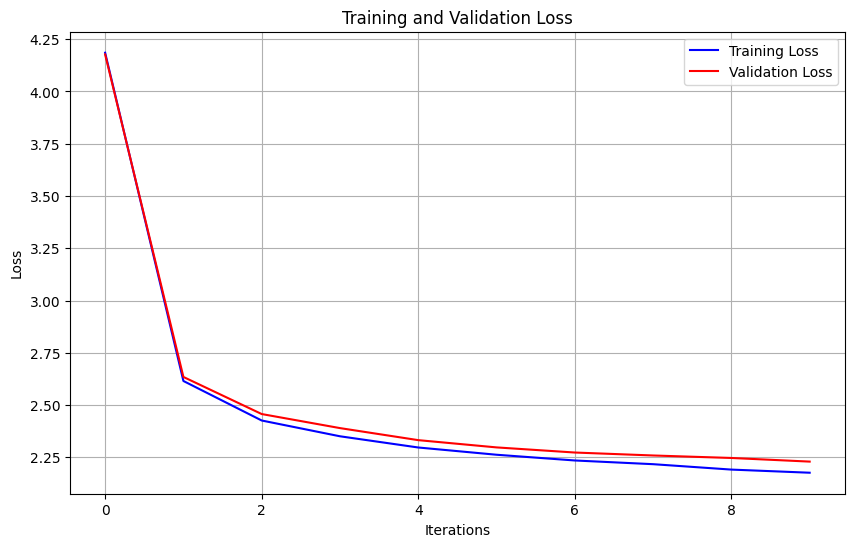

In [217]:
# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(train_lossi, label='Training Loss', color='blue')
plt.plot(val_lossi, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [218]:
sample = model.generate()
display(Markdown(sample))



CAMILORG'd GINGING Ring yome natk;
The wand: heay but in hat cith, thacr! I ingorde
Sew worn sun durt wow him righis rime Hadowne gay fill heate! polad sherit planice thearce?
CFalvold ofor in thet voder,
Nor to.
Thef wor and?

HULENCAUS:
Whiiegiong it coud swama. deatru;
Atheneve warns.

Ifaged pente,
No Wey:
Trou in woay naid my spost supin.

Fruthat,
Al, thave, mis do pren, bost thadect thal bum;
thend care cred;
A wand:

OF as by geiterved sthould wohther:
Al
Tixst vath you seic!

Norage is
Alak hat of lad wainkiter, kened.
Wend he.
-Fiting nost,
Whaly ghis of biiffarle, And a avelf I, lito! I omir bed?

GOMBY IMELOULORTELANIUMPURY:
Thather whour wor angar! sull
Hacrow corest thee of muche tobids lorn foughch-
Bur thy
And caypras to I.

SAMPUEKLAD rave know a tavont sumpese whiscance, ood pat onot chis whmang that go 'ie hor kno selfars court,
Pito orad,
Low parigware frag shouht thave Froserder.
Thou forsed of torsy thun yemoul.

Lof asith-bloom at thre,
My to

MORIZAM:
Ye thaver

# Bring it all together: Create a MHA Decoder Block
![nanogpt-architecture](nanogpt-architecture.png)

In [226]:
class SelfAttentionDecoder(nn.Module):
    def __init__(self, channel_dim, head_dim, block_size, dropout):
        super().__init__()
        self.k_project = nn.Linear(channel_dim, head_dim, bias=False)
        self.q_project = nn.Linear(channel_dim, head_dim, bias=False)
        self.v_project = nn.Linear(channel_dim, head_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        mask = torch.triu(torch.ones(block_size, block_size), diagonal=1).bool()
        self.register_buffer('mask', mask)

    def forward(self, x):
        # x shape: (B, T, C)
        # create keys queries and values
        k, q, v = self.k_project(x), self.q_project(x), self.v_project(x) # all shaped (B, T, H)

        # get the weights
        B, T, H = k.shape
        wei = (q @ k.transpose(-2, -1)) * (H**-0.5) # B,T,H @ B,H,T --> B,T,T
        wei = wei.masked_fill(self.mask[:T, :T], float('-inf')) # B,T,T
        wei = torch.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        # get the out
        out = wei @ v # (B,T,T) @ (B,T,H) -> (B,T,H)
        return out
    
class MultiHeadSelfAttentionDecoderBlock(nn.Module):
    def __init__(self, channel_dim, num_heads, head_dim, block_size, dropout):
        super().__init__()
        # MHA
        self.ln1 = nn.LayerNorm(channel_dim)
        self.mha_decoder = nn.ModuleList([SelfAttentionDecoder(channel_dim, head_dim, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads*head_dim, channel_dim)
        self.dropout1 = nn.Dropout(dropout)
        
        # FFN
        self.ln2 = nn.LayerNorm(channel_dim)
        self.ffn = nn.Sequential(
            nn.Linear(channel_dim, 4 * channel_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4 * channel_dim, channel_dim),
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.proj(torch.cat([head(self.ln1(x)) for head in self.mha_decoder],\
                           dim=-1)) # head (x) -> (B,T,H) * NH -> [B,T,H*NH]
        x = self.dropout1(x)
        x = x + self.ffn(self.ln2(x))
        x = self.dropout2(x)

        return x
    
class NanoGPT(nn.Module):
    def __init__(self, emb_dim, vocab_size, block_size, num_heads, n_layers, dropout, device):
        super().__init__()
        self.device = device
        self.block_size = block_size
        # get the embeddings matrix
        self.tok_embs = nn.Embedding(vocab_size, emb_dim)
        self.pos_embs = nn.Embedding(block_size, emb_dim)

        self.mha_block = nn.Sequential(
            *[MultiHeadSelfAttentionDecoderBlock(emb_dim, num_heads, emb_dim//num_heads, block_size, dropout) for _ in range(n_layers)]
        )
        
        # Final linear layer
        self.ln = nn.LayerNorm(emb_dim)
        self.lm_layer = nn.Linear(emb_dim, vocab_size)

        print(f"No. of parameters: {sum([p.numel() for p in self.parameters()])}")

    def forward(self, x, targets=None):
        # x shape (B, T), targets shape (B, T)
        B, T = x.shape
        token_embs = self.tok_embs(x) #(B,T,C)
        position_embs = self.pos_embs(torch.arange(T).to(self.device)) #(T,C)
        embs = token_embs + position_embs
        embs = self.mha_block(embs)
        logits = self.lm_layer(self.ln(embs))

        if targets is None:
            loss = None
        else:
            B, T, V = logits.shape
            loss = F.cross_entropy(logits.view(B*T, V), targets.view(B*T))

        return logits, loss
    
    def generate(self, max_tokens=1000):
        curr_block, curr_str = torch.LongTensor([[0]]).to(self.device), "\n"

        for _ in range(max_tokens):
            # truncate window to block_size
            curr_block = curr_block[:, -self.block_size:] # [B,R] -> [B,T]

            logits, _ = self(curr_block) # (B,T,V)
            probs = torch.softmax(logits, dim=-1) # (B,T,V)
            B, T, V = probs.shape
            new_char_idx = torch.multinomial(probs.view(B*T, V), num_samples=1, replacement=True)[-1].item()
            curr_str += itos[new_char_idx]
            new_char_idx = torch.LongTensor([new_char_idx]).unsqueeze(0).to(device)
            curr_block = torch.cat([curr_block, new_char_idx], dim=1)

        return curr_str
        

In [227]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
n_iters = 10000
eval_interval = n_iters//10
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
emb_dim = 64
num_heads = 4
n_layers = 2
dropout = 0.2

In [233]:
model = NanoGPT(emb_dim=emb_dim, vocab_size=vocab_size, block_size=block_size, num_heads=num_heads,\
                 n_layers=n_layers, dropout=dropout, device=device)
model = model.to(device)

No. of parameters: 110145


In [234]:
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [235]:
train_lossi, val_lossi = train(train_tokens=train_tokens, val_tokens=val_tokens, model=model, optimizer=optimizer,\
      device=device, block_size=block_size, batch_size=batch_size, n_iters=n_iters, eval_interval=eval_interval)

Step 0/10000 --> Train: 4.2891 | Val: 4.2886
Step 1000/10000 --> Train: 2.6829 | Val: 2.6968
Step 2000/10000 --> Train: 2.5402 | Val: 2.5575
Step 3000/10000 --> Train: 2.4617 | Val: 2.4878
Step 4000/10000 --> Train: 2.4037 | Val: 2.4342
Step 5000/10000 --> Train: 2.3637 | Val: 2.3942
Step 6000/10000 --> Train: 2.3262 | Val: 2.3601
Step 7000/10000 --> Train: 2.2970 | Val: 2.3311
Step 8000/10000 --> Train: 2.2695 | Val: 2.3065
Step 9000/10000 --> Train: 2.2420 | Val: 2.2837


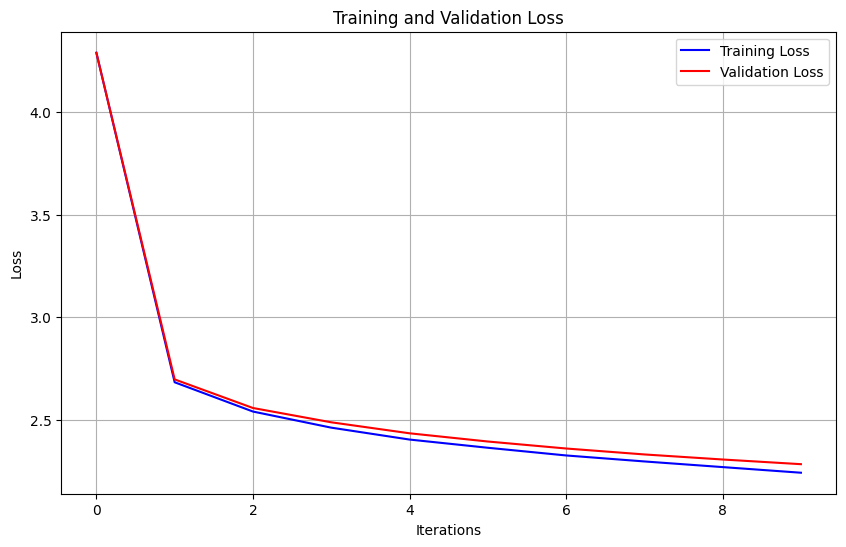

In [236]:
# Plot both losses
plt.figure(figsize=(10, 6))
plt.plot(train_lossi, label='Training Loss', color='blue')
plt.plot(val_lossi, label='Validation Loss', color='red')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [237]:
sample = model.generate()
display(Markdown(sample))


OIN:
Tem ouspry ut luideilc nour Iooy so dounit blon:
Ad kes,
I' t had fat bus to teeet?

ANCedt fompy!, QAUCMEOL:
OUS:
Armeerpiink That hin ant thes hen, Ple tionds thit I ot cotend
Sor se:
Has ais yourrt hus 'nla bpleeeas st't, a trafr thet.
Wthoud, CAvengov ha the, thum trod; me, Ino lere, that and bof hofd s.

ADG 'Ty os win vreshallednen faar mon dud ho ang ounonclle, yooe.

Thaingees, Hur, aniths mon grrpey I;
Thint oot of himo has! ver thabise aitind of wlemrd.

GRCYEESMemoud sheadlen at whon Iin:
Imy at thesesall d An gnon thiccope bler breerp;

orisce,d,
wirnenge ne theid o'gleanl of sor, Thatenepet hach I:
Yomul hand, hurverut then my yer
Bannte, wePome i wallveldy ber hent ufak.
 Me, tiat sas thoonon sin hee from you o elasd, copstamd, proon kre amne crard ing thy e,
If'l aman,
Weda ou deache menot, sAbe rettCounn hasl and sme tin ach wace honcedis fit;
Asharnt eowt be urabllo te toorte wirso wollce worsto chindt mas.


WER:
RAEThitaswis ne sust. 
Ke:

's wicet.


Kt ENG IEL